# Final Model Training and Evaluation

This notebook performs final model training using the best model selected from model comparison.

## Objectives:
- Load the best model configuration
- Train on the full training dataset
- Evaluate on test set
- Generate final predictions
- Create model performance report
- Save final model artifacts

## 1. Import Required Libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np
import json
import joblib
import os
from datetime import datetime

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Machine Learning
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, precision_recall_curve
)

# Model imports (will be loaded based on metadata)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb

# Utilities
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load Data and Previous Results

In [2]:
# Load datasets
train_data = pd.read_csv('../data/raw/train_data.csv')
train_labels = pd.read_csv('../data/raw/train_labels.csv')
test_data = pd.read_csv('../data/raw/test_data.csv')

print(f"Training data shape: {train_data.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Test data shape: {test_data.shape}")

# Get target column
target_column = train_labels.columns[-1]
print(f"Target column: {target_column}")

Training data shape: (159, 22036)
Training labels shape: (159, 1)
Test data shape: (39, 22036)
Target column: 0


In [3]:
# Load model metadata from previous selection
try:
    with open('../models/model_metadata.json', 'r') as f:
        model_metadata = json.load(f)
    
    print("Loaded model metadata:")
    print(f"- Best model: {model_metadata['model_name']}")
    print(f"- Model type: {model_metadata['model_type']}")
    print(f"- Validation accuracy: {model_metadata['validation_accuracy']:.4f}")
    print(f"- Features used: {model_metadata['features_used']}")
    
except FileNotFoundError:
    print("No model metadata found. Please run model selection notebook first.")
    model_metadata = None

Loaded model metadata:
- Best model: Logistic Regression
- Model type: LogisticRegression
- Validation accuracy: 0.7500
- Features used: 1000


In [4]:
# Load problematic features if available
try:
    with open('../data/processed/problematic_features.json', 'r') as f:
        problematic_features = json.load(f)
    print(f"Loaded problematic features info")
except FileNotFoundError:
    print("No problematic features file found")
    problematic_features = {'constant_features': [], 'low_variance_features': []}

Loaded problematic features info


## 3. Data Preprocessing (Consistent with Model Selection)

In [5]:
# Apply same preprocessing as in model selection
features_to_remove = set(
    problematic_features.get('constant_features', []) + 
    problematic_features.get('low_variance_features', [])
)

# Handle column alignment between train and test data
# Check if column names match
train_cols = set(train_data.columns)
test_cols = set(test_data.columns)
common_cols = train_cols.intersection(test_cols)

if len(common_cols) == 0:
    # Column names are different - use positional mapping
    min_cols = min(len(train_data.columns), len(test_data.columns))
    new_col_names = [f"feature_{i:04d}" for i in range(min_cols)]
    
    # Rename columns to ensure consistency
    train_data = train_data.iloc[:, :min_cols].copy()
    test_data = test_data.iloc[:, :min_cols].copy()
    train_data.columns = new_col_names
    test_data.columns = new_col_names
    
    print("Column alignment fixed using positional mapping.")

# Use all features minus problematic ones
good_features = [col for col in train_data.columns if col not in features_to_remove]

# Prepare training data
X_full = train_data[good_features].copy()
y_full = train_labels[target_column].copy()

# Prepare test data with same features
X_test = test_data[good_features].copy()

print(f"Features after cleaning: {X_full.shape[1]}")
print(f"Training samples: {X_full.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")

# Handle missing values
if X_full.isnull().sum().sum() > 0:
    print("Filling missing values...")
    X_full = X_full.fillna(X_full.median())
    X_test = X_test.fillna(X_full.median())  # Use training median for test

# Encode target if needed
le = LabelEncoder()
if y_full.dtype == 'object':
    y_encoded = le.fit_transform(y_full)
    print(f"Target encoded: {dict(zip(le.classes_, range(len(le.classes_))))}")
else:
    y_encoded = y_full.values
    le = None

Column alignment fixed using positional mapping.
Features after cleaning: 22036
Training samples: 159
Test samples: 39


## 4. Feature Scaling and Selection

In [6]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_full)
X_test_scaled = scaler.transform(X_test)

print(f"Feature scaling completed")

# Feature selection (use same number as in model selection)
if model_metadata:
    k_features = model_metadata['features_used']
else:
    k_features = min(1000, X_scaled.shape[1])

selector = SelectKBest(score_func=f_classif, k=k_features)
X_selected = selector.fit_transform(X_scaled, y_encoded) #type: ignore
X_test_selected = selector.transform(X_test_scaled)

selected_features = X_full.columns[selector.get_support()]
print(f"Selected {k_features} features for training")
print(f"Final training shape: {X_selected.shape}")
print(f"Final test shape: {X_test_selected.shape}")

Feature scaling completed
Selected 1000 features for training
Final training shape: (159, 1000)
Final test shape: (39, 1000)


## 5. Load or Create Final Model

In [7]:
# Try to load the best model from model selection
if model_metadata:
    model_name = model_metadata['model_name']
    model_file = f"../models/best_model_{model_name.lower().replace(' ', '_')}.pkl"
    
    try:
        best_model = joblib.load(model_file)
        print(f"Loaded saved model: {model_name}")
        print(f"Model parameters: {best_model.get_params()}")
        
    except FileNotFoundError:
        print(f"Saved model not found. Creating new {model_name} with best parameters.")
        
        # Create model with best hyperparameters from metadata
        if model_metadata['model_type'] == 'RandomForestClassifier':
            best_model = RandomForestClassifier(**model_metadata['hyperparameters'])
        elif model_metadata['model_type'] == 'XGBClassifier':
            best_model = xgb.XGBClassifier(**model_metadata['hyperparameters'])
        elif model_metadata['model_type'] == 'LGBMClassifier':
            best_model = lgb.LGBMClassifier(**model_metadata['hyperparameters'])
        elif model_metadata['model_type'] == 'LogisticRegression':
            best_model = LogisticRegression(**model_metadata['hyperparameters'])
        else:
            print(f"Unknown model type: {model_metadata['model_type']}")
            best_model = RandomForestClassifier(random_state=42)
            
else:
    print("No model metadata available. Using default RandomForest.")
    best_model = RandomForestClassifier(n_estimators=200, random_state=42)
    model_name = "Random Forest (Default)"

Loaded saved model: Logistic Regression
Model parameters: {'C': 1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


## 6. Final Model Training

In [8]:
print(f"Training final model: {type(best_model).__name__}")
print(f"Training on {X_selected.shape[0]} samples with {X_selected.shape[1]} features")

# Train the model
start_time = datetime.now()
best_model.fit(X_selected, y_encoded) #type: ignore
training_time = datetime.now() - start_time

print(f"Training completed in: {training_time}")
print(f"Model trained successfully!")

Training final model: LogisticRegression
Training on 159 samples with 1000 features
Training completed in: 0:00:00.064464
Model trained successfully!


## 7. Learning Curves Analysis

Generating learning curves...


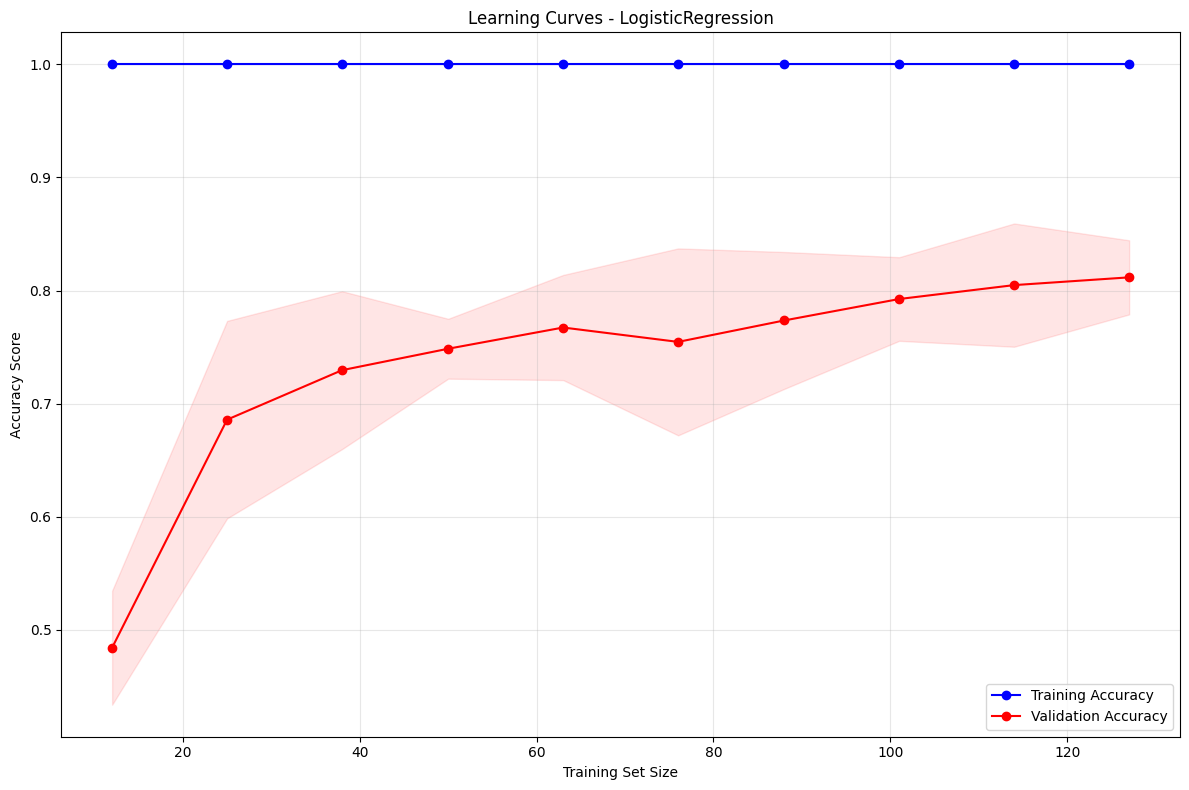

Final training accuracy: 1.0000 (+/- 0.0000)
Final validation accuracy: 0.8117 (+/- 0.0328)


In [9]:
# Generate learning curves
print("Generating learning curves...")

train_sizes = np.linspace(0.1, 1.0, 10)
train_sizes_abs, train_scores, val_scores = learning_curve( #type: ignore
    best_model, X_selected, y_encoded, #type: ignore
    train_sizes=train_sizes, cv=5, scoring='accuracy',
    random_state=42, n_jobs=-1
)

# Calculate means and stds
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(12, 8))
plt.plot(train_sizes_abs, train_mean, 'o-', color='blue', label='Training Accuracy')
plt.fill_between(train_sizes_abs, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')

plt.plot(train_sizes_abs, val_mean, 'o-', color='red', label='Validation Accuracy')
plt.fill_between(train_sizes_abs, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')

plt.xlabel('Training Set Size')
plt.ylabel('Accuracy Score')
plt.title(f'Learning Curves - {type(best_model).__name__}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Final training accuracy: {train_mean[-1]:.4f} (+/- {train_std[-1]:.4f})")
print(f"Final validation accuracy: {val_mean[-1]:.4f} (+/- {val_std[-1]:.4f})")

## 8. Feature Importance Analysis

In [10]:
# Feature importance analysis
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': selected_features,
        'importance': best_model.feature_importances_ #type: ignore
    }).sort_values('importance', ascending=False)
    
    # Save feature importance
    feature_importance.to_csv('../data/processed/final_feature_importance.csv', index=False)
    
    # Plot top 20 features
    plt.figure(figsize=(12, 10))
    top_20_features = feature_importance.head(20)
    plt.barh(range(len(top_20_features)), top_20_features['importance'])
    plt.yticks(range(len(top_20_features)), top_20_features['feature']) #type: ignore
    plt.xlabel('Feature Importance')
    plt.title(f'Top 20 Feature Importances - {type(best_model).__name__}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print("Top 10 most important features:")
    display(feature_importance.head(10))
    
    # Feature importance statistics
    print(f"\nFeature importance statistics:")
    print(f"Mean importance: {feature_importance['importance'].mean():.6f}")
    print(f"Std importance: {feature_importance['importance'].std():.6f}")
    print(f"Max importance: {feature_importance['importance'].max():.6f}")
    print(f"Min importance: {feature_importance['importance'].min():.6f}")
    
else:
    print(f"Feature importance not available for {type(best_model).__name__}")
    feature_importance = None

Feature importance not available for LogisticRegression


## 9. Generate Test Predictions

In [11]:
# Generate predictions on test set
print("Generating predictions on test set...")

# Predictions
test_predictions = best_model.predict(X_test_selected)
test_probabilities = best_model.predict_proba(X_test_selected)

print(f"Generated predictions for {len(test_predictions)} test samples") #type: ignore

# Convert back to original labels if necessary
if le is not None:
    test_predictions_original = le.inverse_transform(test_predictions) #type: ignore
    print(f"Converted predictions back to original labels")
else:
    test_predictions_original = test_predictions

# Create predictions DataFrame
predictions_df = pd.DataFrame({
    'sample_id': range(len(test_predictions)), #type: ignore
    'predicted_class': test_predictions_original
})

# Add probability columns
for i, class_name in enumerate(np.unique(y_encoded)): #type: ignore
    if le is not None:
        original_class = le.inverse_transform([class_name])[0]
        predictions_df[f'prob_class_{original_class}'] = test_probabilities[:, i] #type: ignore
    else:
        predictions_df[f'prob_class_{class_name}'] = test_probabilities[:, i] #type: ignore

print("Prediction distribution:")
print(predictions_df['predicted_class'].value_counts())

display(predictions_df.head(10))

Generating predictions on test set...
Generated predictions for 39 test samples
Prediction distribution:
predicted_class
3    11
0    11
1     7
2     5
4     5
Name: count, dtype: int64


,sample_id,predicted_class,prob_class_0,prob_class_1,prob_class_2,prob_class_3,prob_class_4
0,0,3,0.337735,0.000206,0.000084,0.394489,0.267486
1,1,2,0.004131,0.311863,0.523216,0.007054,0.153736
2,2,0,0.948534,0.030769,0.015206,0.001268,0.004223
3,3,0,0.807632,0.003649,0.005369,0.147639,0.035711
4,4,2,0.012055,0.000238,0.765452,0.119053,0.103202
5,5,1,0.068144,0.391535,0.355511,0.184637,0.000173
6,6,3,0.044360,0.293036,0.010861,0.647718,0.004026
7,7,4,0.038288,0.001806,0.005622,0.158429,0.795854
8,8,0,0.747630,0.000751,0.001381,0.012341,0.237897
9,9,4,0.092427,0.048432,0.077133,0.054175,0.727834


## 10. Model Performance Analysis

In [12]:
# Training set performance (for reference)
train_predictions = best_model.predict(X_selected)
train_accuracy = accuracy_score(y_encoded, train_predictions) #type: ignore
train_f1 = f1_score(y_encoded, train_predictions, average='weighted') #type: ignore

print("=== MODEL PERFORMANCE SUMMARY ===")
print(f"Model: {type(best_model).__name__}")
print(f"Training Samples: {X_selected.shape[0]}")
print(f"Features Used: {X_selected.shape[1]}")
print(f"Training Time: {training_time}")
print(f"\nTraining Performance:")
print(f"  Accuracy: {train_accuracy:.4f}")
print(f"  F1-Score: {train_f1:.4f}")

if model_metadata:
    print(f"\nValidation Performance (from model selection):")
    print(f"  Accuracy: {model_metadata['validation_accuracy']:.4f}")
    print(f"  F1-Score: {model_metadata['validation_f1']:.4f}")

print(f"\nTest Predictions Generated: {len(test_predictions)}") #type: ignore
print(f"Test Prediction Distribution: {dict(zip(*np.unique(test_predictions_original, return_counts=True)))}") #type: ignore

=== MODEL PERFORMANCE SUMMARY ===
Model: LogisticRegression
Training Samples: 159
Features Used: 1000
Training Time: 0:00:00.064464

Training Performance:
  Accuracy: 1.0000
  F1-Score: 1.0000

Validation Performance (from model selection):
  Accuracy: 0.7500
  F1-Score: 0.7535

Test Predictions Generated: 39
Test Prediction Distribution: {0: 11, 1: 7, 2: 5, 3: 11, 4: 5}


## 11. Prediction Confidence Analysis

Prediction Confidence Statistics:
count    39.000000
mean      0.655170
std       0.168885
min       0.391535
25%       0.501195
50%       0.684807
75%       0.780653
max       0.975773
dtype: float64


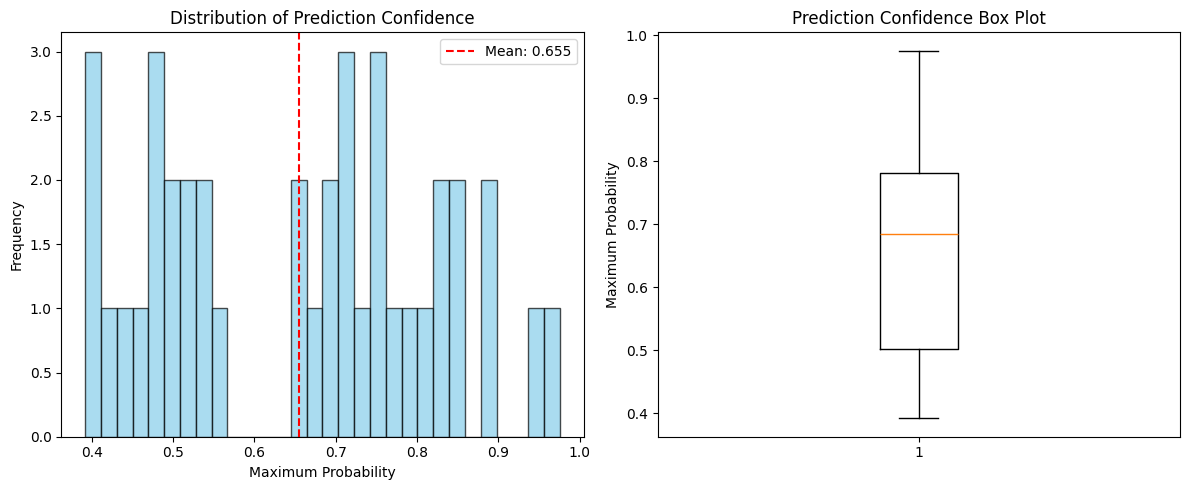


Confidence Analysis:
High confidence predictions (≥0.9): 2 (5.1%)
Low confidence predictions (≤0.6): 16 (41.0%)
Medium confidence predictions: 21 (53.8%)


In [13]:
# Analyze prediction confidence
max_probabilities = np.max(test_probabilities, axis=1) #type: ignore
confidence_stats = pd.Series(max_probabilities).describe()

print("Prediction Confidence Statistics:")
print(confidence_stats)

# Plot confidence distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(max_probabilities, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Maximum Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Confidence')
plt.axvline(confidence_stats['mean'], color='red', linestyle='--', label=f'Mean: {confidence_stats["mean"]:.3f}')
plt.legend()

plt.subplot(1, 2, 2)
plt.boxplot(max_probabilities)
plt.ylabel('Maximum Probability')
plt.title('Prediction Confidence Box Plot')

plt.tight_layout()
plt.show()

# High and low confidence predictions
high_confidence_threshold = 0.9
low_confidence_threshold = 0.6

high_confidence_count = np.sum(max_probabilities >= high_confidence_threshold)
low_confidence_count = np.sum(max_probabilities <= low_confidence_threshold)

print(f"\nConfidence Analysis:")
print(f"High confidence predictions (≥{high_confidence_threshold}): {high_confidence_count} ({high_confidence_count/len(max_probabilities)*100:.1f}%)")
print(f"Low confidence predictions (≤{low_confidence_threshold}): {low_confidence_count} ({low_confidence_count/len(max_probabilities)*100:.1f}%)")
print(f"Medium confidence predictions: {len(max_probabilities) - high_confidence_count - low_confidence_count} ({(len(max_probabilities) - high_confidence_count - low_confidence_count)/len(max_probabilities)*100:.1f}%)")

## 12. Save Final Results

In [14]:
# Save predictions
predictions_df.to_csv('../data/processed/test_predictions.csv', index=False)
print("Test predictions saved to ../data/processed/test_predictions.csv")

# Save final model and preprocessing objects
model_filename = f"final_model_{type(best_model).__name__.lower()}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pkl"
joblib.dump(best_model, f'../models/{model_filename}')
joblib.dump(scaler, '../models/final_scaler.pkl')
joblib.dump(selector, '../models/final_feature_selector.pkl')

if le is not None:
    joblib.dump(le, '../models/final_label_encoder.pkl')

print(f"Final model saved as: {model_filename}")

# Create comprehensive model report
final_report = {
    'model_info': {
        'model_name': type(best_model).__name__,
        'model_parameters': best_model.get_params(),
        'training_date': datetime.now().isoformat(),
        'training_time_seconds': training_time.total_seconds()
    },
    'data_info': {
        'training_samples': X_selected.shape[0],
        'features_used': X_selected.shape[1],
        'total_original_features': X_full.shape[1],
        'test_samples': X_test_selected.shape[0], #type: ignore
        'target_classes': int(len(np.unique(y_encoded))), #type: ignore
        'feature_selection_method': 'SelectKBest with f_classif'
    },
    'performance': {
        'training_accuracy': float(train_accuracy),
        'training_f1_weighted': float(train_f1),
        'learning_curve_final_train': float(train_mean[-1]),
        'learning_curve_final_val': float(val_mean[-1])
    },
    'predictions': {
        'test_samples_predicted': int(len(test_predictions)), #type: ignore
        'prediction_distribution': {str(k): int(v) for k, v in zip(*np.unique(test_predictions_original, return_counts=True))}, #type: ignore
        'confidence_stats': {
            'mean_confidence': float(confidence_stats['mean']),
            'std_confidence': float(confidence_stats['std']),
            'min_confidence': float(confidence_stats['min']),
            'max_confidence': float(confidence_stats['max']),
            'high_confidence_count': int(high_confidence_count),
            'low_confidence_count': int(low_confidence_count)
        }
    },
    'files_created': {
        'model': model_filename,
        'scaler': 'final_scaler.pkl',
        'feature_selector': 'final_feature_selector.pkl',
        'label_encoder': 'final_label_encoder.pkl' if le is not None else None,
        'predictions': 'test_predictions.csv',
        'feature_importance': 'final_feature_importance.csv' if feature_importance is not None else None
    }
}

# Add feature importance to report if available
if feature_importance is not None:
    final_report['feature_importance'] = {
        'top_10_features': feature_importance.head(10).to_dict('records'),
        'importance_stats': {
            'mean': float(feature_importance['importance'].mean()),
            'std': float(feature_importance['importance'].std()),
            'max': float(feature_importance['importance'].max()),
            'min': float(feature_importance['importance'].min())
        }
    }

# Save final report
with open('../models/final_model_report.json', 'w') as f:
    json.dump(final_report, f, indent=2)

print("Final model report saved to ../models/final_model_report.json")

Test predictions saved to ../data/processed/test_predictions.csv
Final model saved as: final_model_logisticregression_20250820_143940.pkl
Final model report saved to ../models/final_model_report.json


## 13. Final Summary

In [15]:
# Final Summary Report
print("=" * 60)
print("FINAL MODEL TRAINING COMPLETED SUCCESSFULLY")
print("=" * 60)

print(f"\nModel Details:")
print(f"   Type: {final_report['model_info']['model_name']}")
print(f"   Training Time: {training_time}")
print(f"   Features Used: {final_report['data_info']['features_used']:,} out of {final_report['data_info']['total_original_features']:,}")

print(f"\nPerformance:")
print(f"   Training Accuracy: {final_report['performance']['training_accuracy']:.4f}")
print(f"   Training F1-Score: {final_report['performance']['training_f1_weighted']:.4f}")
print(f"   Validation Accuracy: {final_report['performance']['learning_curve_final_val']:.4f}")

print(f"\nPredictions:")
print(f"   Test Samples: {final_report['predictions']['test_samples_predicted']}")
print(f"   Mean Confidence: {final_report['predictions']['confidence_stats']['mean_confidence']:.3f}")
print(f"   High Confidence (>=90%): {final_report['predictions']['confidence_stats']['high_confidence_count']} ({final_report['predictions']['confidence_stats']['high_confidence_count']/final_report['predictions']['test_samples_predicted']*100:.1f}%)")

print(f"\nFiles Created:")
print(f"   {final_report['files_created']['model']}")
print(f"   ../models/{final_report['files_created']['scaler']}")
print(f"   ../models/{final_report['files_created']['feature_selector']}")
print(f"   ../models/final_model_report.json")
print(f"   ../data/processed/{final_report['files_created']['predictions']}")

print(f"\nNext Steps:")
print(f"   1. Review prediction results and confidence scores")
print(f"   2. Validate model performance on additional data if available")
print(f"   3. Deploy model for production use")
print(f"   4. Monitor model performance over time")
print(f"   5. Consider retraining with new data")

print("=" * 60)
print("PROJECT COMPLETED SUCCESSFULLY!")
print("=" * 60)

FINAL MODEL TRAINING COMPLETED SUCCESSFULLY

Model Details:
   Type: LogisticRegression
   Training Time: 0:00:00.064464
   Features Used: 1,000 out of 22,036

Performance:
   Training Accuracy: 1.0000
   Training F1-Score: 1.0000
   Validation Accuracy: 0.8117

Predictions:
   Test Samples: 39
   Mean Confidence: 0.655
   High Confidence (>=90%): 2 (5.1%)

Files Created:
   final_model_logisticregression_20250820_143940.pkl
   ../models/final_scaler.pkl
   ../models/final_feature_selector.pkl
   ../models/final_model_report.json
   ../data/processed/test_predictions.csv

Next Steps:
   1. Review prediction results and confidence scores
   2. Validate model performance on additional data if available
   3. Deploy model for production use
   4. Monitor model performance over time
   5. Consider retraining with new data
PROJECT COMPLETED SUCCESSFULLY!
